# EDA for Ground Truth Data

In this notebook, we will attempt to perform EDA to understand the different indices related to cropland. The idea is to:
1. See if we our data is correct in terms of the labels with a visual inspection
2. To see if we can identify additional features that help with identifying if there is evidence of irrigation and vegetation in the image

## Load Google Drive

Load our drive to be able to load the csv data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys
import os
BASE_PATH = '/content/gdrive/My Drive/capstone_code'
sys.path.append(BASE_PATH)
os.chdir(BASE_PATH)
IRR_DATA_DIR = 'CroplandDataSet/2017-2020/Irrigated'
RF_DATA_DIR = 'CroplandDataSet/2017-2020/Rainfed'
os.listdir(IRR_DATA_DIR)

['S2SR_3_2020_50.86366254_4.35937945_msi_B4.tif',
 'S2SR_3_2020_50.86366254_4.35937945_msi_B2.tif',
 'S2SR_3_2020_50.86366254_4.35937945_msi_B6.tif',
 'S2SR_3_2020_50.86366254_4.35937945_msi_B3.tif',
 'S2SR_3_2020_50.86366254_4.35937945_msi_B5.tif',
 'S2SR_3_2020_50.86366254_4.35937945_msi_B7.tif',
 'S2SR_3_2020_50.86366254_4.35937945_msi_B8.tif',
 'S2SR_3_2020_50.86366254_4.35937945_msi_B8A.tif',
 'S2SR_3_2020_50.86366254_4.35937945_msi_B11.tif',
 'S2SR_3_2020_50.86366254_4.35937945_msi_B12.tif',
 'S2SR_8_2019_35.17756126_-111.6804034_msi_B3.tif',
 'S2SR_8_2019_35.17756126_-111.6804034_msi_B4.tif',
 'S2SR_8_2019_35.17756126_-111.6804034_msi_B5.tif',
 'S2SR_8_2019_35.17756126_-111.6804034_msi_B6.tif',
 'S2SR_8_2019_35.17756126_-111.6804034_msi_B2.tif',
 'S2SR_8_2019_35.17756126_-111.6804034_msi_B8.tif',
 'S2SR_8_2019_35.17756126_-111.6804034_msi_B7.tif',
 'S2SR_8_2019_35.17756126_-111.6804034_msi_B8A.tif',
 'S2SR_8_2019_35.17756126_-111.6804034_msi_B11.tif',
 'S2SR_8_2019_35.17756126_-

In [3]:
import tarfile
import os
import numpy as np
import PIL
import gdal
import folium
from matplotlib import pyplot as plt
import cv2
import pandas as pd
%matplotlib inline
from google.colab import files

In [4]:
import time
from math import sin, cos, sqrt, atan2, radians
import ee
from shapely.geometry import box
from scipy.signal import find_peaks

# Helper Methods
def plot_map(self):
        '''Plot folium map using GEE api - the map includes are of interest box and associated ndvi readings'''

        def add_ee_layer(self, ee_object, vis_params, show, name):
            '''Checks if image object classifies as ImageCollection, FeatureCollection, Geometry or single Image
            and adds to folium map accordingly'''
            try:
                if isinstance(ee_object, ee.image.Image):
                    map_id_dict = ee.Image(ee_object).getMapId(vis_params)
                    folium.raster_layers.TileLayer(
                        tiles=map_id_dict['tile_fetcher'].url_format,
                        attr='Google Earth Engine',
                        name=name,
                        overlay=True,
                        control=True,
                        show=show
                    ).add_to(self)
                elif isinstance(ee_object, ee.imagecollection.ImageCollection):
                    ee_object_new = ee_object.median()
                    map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
                    folium.raster_layers.TileLayer(
                        tiles=map_id_dict['tile_fetcher'].url_format,
                        attr='Google Earth Engine',
                        name=name,
                        overlay=True,
                        control=True,
                        show=show
                    ).add_to(self)
                elif isinstance(ee_object, ee.geometry.Geometry):
                    folium.GeoJson(
                        data=ee_object.getInfo(),
                        name=name,
                        overlay=True,
                        control=True
                    ).add_to(self)
                elif isinstance(ee_object, ee.featurecollection.FeatureCollection):
                    ee_object_new = ee.Image().paint(ee_object, 0, 2)
                    map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
                    folium.raster_layers.TileLayer(
                        tiles=map_id_dict['tile_fetcher'].url_format,
                        attr='Google Earth Engine',
                        name=name,
                        overlay=True,
                        control=True,
                        show=show
                    ).add_to(self)

            except:
                print("Could not display {}".format(name))

        # Add EE drawing method to folium.
        folium.Map.add_ee_layer = add_ee_layer

        myMap = folium.Map(location=[self.center_lat, self.center_lon], zoom_start=11)
        #aoi_shapely = self.__create_bounding_box_shapely()
        #folium.GeoJson(aoi_shapely, name="Area of Interest").add_to(myMap)

        
        # Add Sentinel-2 RGB quarterly layers
        start = time.time()
        visParams = {'max': 3000}
        # Add MSI layer for July
        myMap.add_ee_layer(self.Sentinel_MSI.select(['B2','B3','B4']), visParams, show=False, name="Sentinel2A")
        end = time.time()
        print("ADDED S2 RGB LAYERS \t\t--> " + str(round((end - start) / 60, 2)) + " min")

        return myMap

## Create RGB Bands for Visualization

Lets view the satellite images we download for each ground truth location from crop land and visualize them using their RGB information

In [5]:
# Spectral band names to read related GeoTIFF files
band_names = ['B2', 'B3', 'B4', 'B5', 'B6',
              'B7', 'B8', 'B8A', 'B11', 'B12']

rgb_names = ['B4', 'B3', 'B2']
ag_names = ['B11', 'B12', 'B8A']
band_combinations = [rgb_names, ag_names]

SCALE_FACTOR = 3000

def plot_band_combs(foldername, base_paths, band_combinations, scale = SCALE_FACTOR):
  '''
  This function is used to visualize a set of images at a fixed latitude 
  and varying longitudes. he function can take multiple band combinations
  which will be plotted as separate rows.
  '''
  imarrays = []
  for comb in band_combinations:
    for base_path in base_paths:
      for b, band_name in enumerate(comb):
        #print(base_path)
        # First finds related GeoTIFF path and reads values as an array
        band_path = os.path.join(foldername, f'{base_path}_msi_{band_name}.tif')
        band_ds = gdal.Open(band_path,  gdal.GA_ReadOnly)
        raster_band = band_ds.GetRasterBand(1)
        band_data = raster_band.ReadAsArray()
        #print(band_data.shape)
        if b == 0:
            imarray = np.zeros((3404, 2784,3))
        if band_data.shape != imarray.shape[:2]:
            band_data = cv2.resize(band_data, (imarray.shape[1],imarray.shape[0]))
        imarray[:,:,b] = band_data / scale

      imarrays.append(imarray)

  fix, axes = plt.subplots(ncols=len(base_paths),
                            nrows=len(band_combinations),
                            sharex=True,
                            sharey=True,
                            figsize=(4*len(base_paths),6*len(band_combinations)))
  axes = axes.flatten()
  for i, img in enumerate(imarrays):
    axes[i].imshow(img)
  for ax in axes:
    ax.set_axis_off()
        
  plt.subplots_adjust(hspace=0.0,wspace=0.0)

### 1. Irrigated Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


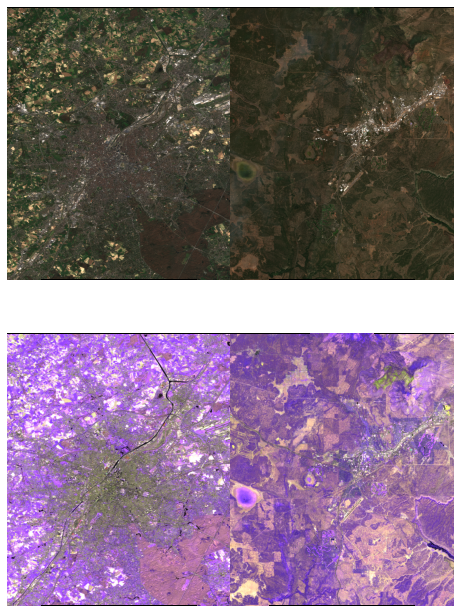

In [ ]:
base_paths = ['S2SR_3_2020_50.86366254_4.35937945', 'S2SR_8_2019_35.17756126_-111.6804034' ]

# Call the plot function
plot_band_combs(os.path.join(BASE_PATH, IRR_DATA_DIR), base_paths, band_combinations)

### 2. Not Irrigated

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


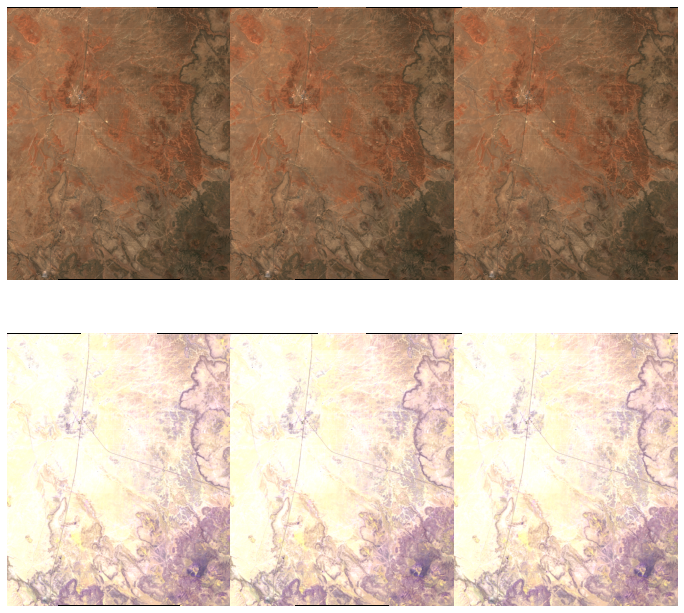

In [ ]:
base_paths = ['S2SR_8_2019_35.6063255_-112.09746937', 'S2SR_8_2019_35.60624445_-112.09743470000001', 'S2SR_8_2019_35.60636315_-112.09750749999999']

# Call the plot function
plot_band_combs(os.path.join(BASE_PATH, RF_DATA_DIR), base_paths, band_combinations)

## Vegetative Indices

We are interested in seeing the enhanced vegetative index (EVI), soil adjusted vegetative index (SAVI), Moisture stress index (MSI) etc. of these locations

$EVI = 2.5(NIR - Red)/(NIR + 6 * Red - 7.5 * Blue + 1)$

$SAVI = (1 + L)(NIR - Red)/(NIR + Red + L)$ where L = 0.5 (canopy background adjustment factor)

- Moisture Stress Index: This index is a reflectance measurement that is sensitive to increasing leaf water content. As the water content of leaves in vegetation canopies increases, the strength of the absorption around 1599 nm increases. Absorption at 819 nm is nearly unaffected by changing water content, so it is used as the reference. Applications include canopy stress analysis, productivity prediction and modeling, fire hazard condition analysis, and studies of ecosystem physiology. The MSI is inverted relative to the other water VIs; higher values indicate greater water stress and less water content. 

$MSI = MidIR/ NIR$ or here we use SWIR (band 11)/NIR (band 8)

- Normalized Difference Infrared Index: This index is a reflectance measurement that is sensitive to changes in water content of plant canopies. The NDII uses a normalized difference formulation instead of a simple ratio, and the index values increase with increasing water content. Applications include crop agricultural management, forest canopy monitoring, and vegetation stress detection.

$NDII = (NIR - MIR)/ (NIR + MIR)$

- Normalized Multi-band Drought Index (NMDI): This index takes into account a soil moisture background to monitor potential drought conditions. Three specific bands were chosen because of their unique response to variations in soil and vegetation moisture. The index uses the difference between two liquid-water absorption bands in the shortwave-infrared region (1640 and 2130 nm) as a measure of water sensitivity in vegetation and soil. This index is also commonly used in forest-fire detection.

As soil moisture increases, the index values decrease. Index values range from 0.7 to 1 for dry soil, 0.6 to 0.7 for soil with intermediate moisture, and less than 0.6 for wet soil.

$NMDI = (NIR - (SWIR1 - SWIR2)) / (NIR + (SWIR1 - SWIR2))$

- Water Band Index (WBI): This index is a reflectance measurement that is sensitive to changes in canopy water status. As the water content of vegetation canopies increases, the strength of the absorption around 970 nm increases relative to that of 900 nm. Applications include canopy stress analysis, productivity prediction and modeling, fire hazard condition analysis, cropland management, and studies of ecosystem physiology.

$WBI = Band-9 / Band-8A $


In [29]:
import matplotlib as mpl

def get_band_data(band_path):
  band_ds = gdal.Open(band_path,  gdal.GA_ReadOnly)
  raster_band = band_ds.GetRasterBand(1)
  return raster_band.ReadAsArray()

def plot_vegetative_moisture_index(folderpath, base_paths, index, scale = SCALE_FACTOR):
    imarrays = []
    nrows, ncols = np.shape(base_paths)
    
    assert(index in 'EVI SAVI NDII NMDI'.split())
    
    if index == 'EVI':
      color_map = 'RdYlGn'
      for row in base_paths:
        for base_path in row:
            # First finds related GeoTIFF path and reads values as an array
            nir_data = get_band_data(os.path.join(folderpath,f'{base_path}_msi_B8.tif'))
            red_data = get_band_data(os.path.join(folderpath,f'{base_path}_msi_B4.tif'))
            blue_data = get_band_data(os.path.join(folderpath,f'{base_path}_msi_B2.tif'))

            # Since the blue band is only added to decrease noise this variant of EVI called EVI2 
            # serves as a good proxy indicator for EVI 
            # -- dual band EVI2
            imarray = 2.5 * ((nir_data - red_data) / (nir_data + (2.4 * red_data) + 1))
            imarrays.append(imarray)
    elif index == 'SAVI':
      color_map = 'RdYlGn'
      for row in base_paths:
        for base_path in row:
            nir_data = get_band_data(os.path.join(folderpath,f'{base_path}_msi_B8.tif'))
            red_data = get_band_data(os.path.join(folderpath,f'{base_path}_msi_B4.tif'))
                        
            imarray = 1.5*(nir_data-red_data) / (nir_data + red_data + 0.5)
            imarrays.append(imarray)
    elif index == 'NMDI':
      color_map = 'BrBG' #mpl.cm.Blues
      for row in base_paths:
        for base_path in row:
            nir_data = get_band_data(os.path.join(folderpath,f'{base_path}_msi_B8.tif'))
            sw1_data = get_band_data(os.path.join(folderpath,f'{base_path}_msi_B11.tif'))
            sw2_data = get_band_data(os.path.join(folderpath,f'{base_path}_msi_B12.tif'))
            # --- Normalized Difference Infrared Index
            imarray = (nir_data - (sw1_data - sw2_data))/ (nir_data + (sw1_data + sw2_data))
            imarrays.append(imarray)
    elif index == 'NDII':
      color_map = 'BrBG' #mpl.cm.Blues
      for row in base_paths:
        for base_path in row:
            nir_data = get_band_data(os.path.join(folderpath,f'{base_path}_msi_B8.tif'))
            mir_data = get_band_data(os.path.join(folderpath,f'{base_path}_msi_B11.tif'))
            # --- Normalized Difference Infrared Index
            imarray = (nir_data - mir_data)/ (nir_data + mir_data)
            imarrays.append(imarray)

    fix, axes = plt.subplots(ncols=ncols,
                             nrows=nrows,
                             sharex=True,
                             sharey=True,
                             figsize=(4*ncols,6*nrows))
    axes = axes.flatten()
    for i, img in enumerate(imarrays):
        im = axes[i].imshow(img, cmap=color_map)

    for ax in axes:
        ax.set_axis_off()

    # Colorbar
    fix.colorbar(im, ax=axes.ravel().tolist(), shrink=0.75, pad = 0.05)
        
    plt.subplots_adjust(hspace=0.1,wspace=0.1)
    ret = [np.nanmedian(x) for x in imarrays]
    print(ret)
    return ret
    
    

### 1. Irrigated Data

[0.8654079835145823, 0.8922827231255117]
[0.7105591785763841, 0.7282243729014418]
[0.03635014836795252, 0.016235993597072947]
[0.29984202211690364, 0.27199136535348084]


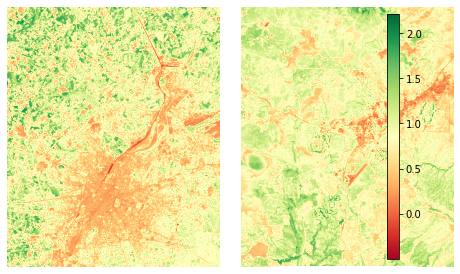

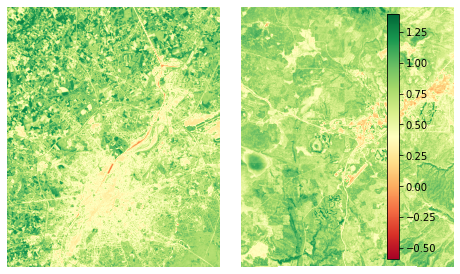

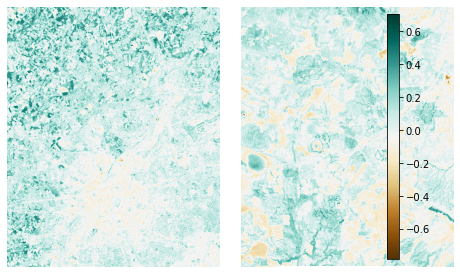

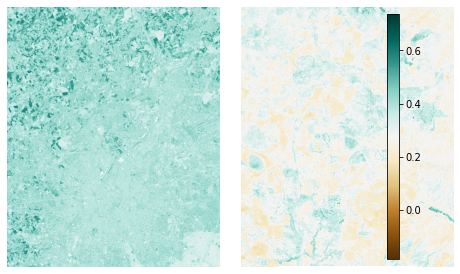

In [26]:
base_paths = [['S2SR_3_2020_50.86366254_4.35937945', 'S2SR_8_2019_35.17756126_-111.6804034' ]]

evi2 = plot_vegetative_moisture_index(os.path.join(BASE_PATH, IRR_DATA_DIR), base_paths, 'EVI')
savi = plot_vegetative_moisture_index(os.path.join(BASE_PATH, IRR_DATA_DIR), base_paths, 'SAVI')
msi = plot_vegetative_moisture_index(os.path.join(BASE_PATH, IRR_DATA_DIR), base_paths, 'NDII')
nmdi = plot_vegetative_moisture_index(os.path.join(BASE_PATH, IRR_DATA_DIR), base_paths, 'NMDI')

      EVI  SAVI  NDII  NMDI
EVI   1.0   1.0  -1.0  -1.0
SAVI  1.0   1.0  -1.0  -1.0
NDII -1.0  -1.0   1.0   1.0
NMDI -1.0  -1.0   1.0   1.0


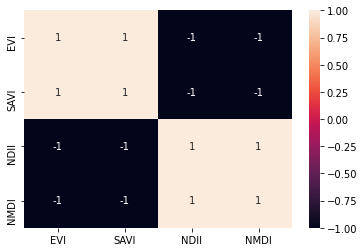

In [27]:
# Compute correlation matrix for these readings
import seaborn as sn
import matplotlib.pyplot as plt

data = {'EVI': evi2,
        'SAVI': savi,
        'NDII': msi,
        'NMDI' : nmdi
        }

df = pd.DataFrame(data,columns=['EVI','SAVI','NDII', 'NMDI'])
df.head()
corrMatrix = df.corr()
print (corrMatrix)
sn.heatmap(corrMatrix, annot=True)
plt.show()


### 2. Not Irrigated data

[0.3189597006685886, 0.31898539584934665, 0.31889354688451754]
[0.2986717721670456, 0.2986944061140006, 0.2986150208309875]
[-0.13183047790802524, -0.13182157986543733, -0.13185002060156573]
[0.2408741594620557, 0.24087762524932535, 0.24086946927066094]


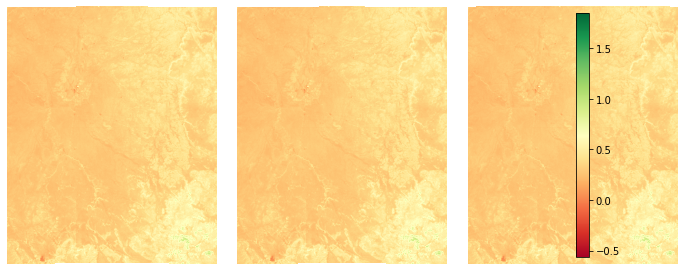

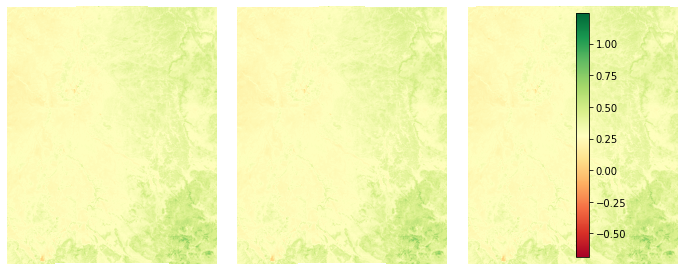

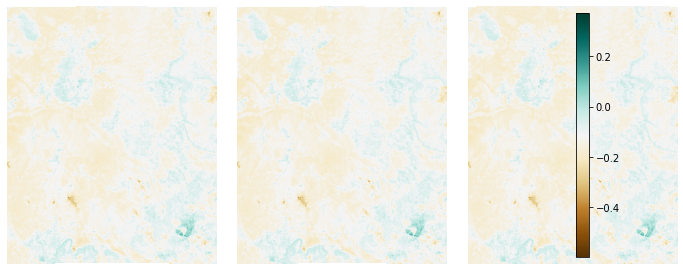

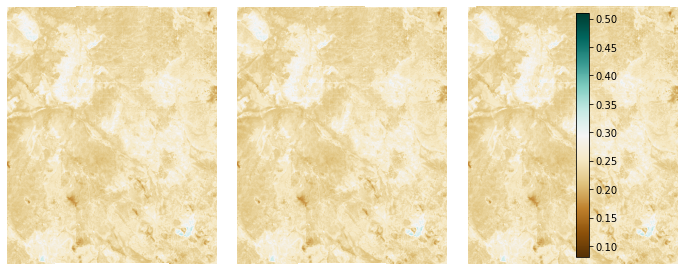

In [31]:
base_paths = [['S2SR_8_2019_35.6063255_-112.09746937', 'S2SR_8_2019_35.60624445_-112.09743470000001', 'S2SR_8_2019_35.60636315_-112.09750749999999']]
evi2 = plot_vegetative_moisture_index(os.path.join(BASE_PATH, RF_DATA_DIR), base_paths, 'EVI')
savi = plot_vegetative_moisture_index(os.path.join(BASE_PATH, RF_DATA_DIR), base_paths, 'SAVI')
msi = plot_vegetative_moisture_index(os.path.join(BASE_PATH, RF_DATA_DIR), base_paths, 'NDII')
nmdi = plot_vegetative_moisture_index(os.path.join(BASE_PATH, RF_DATA_DIR), base_paths, 'NMDI')

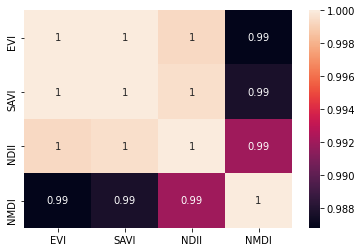

In [33]:
# Compute correlation matrix for these readings
import seaborn as sn
import matplotlib.pyplot as plt

data = {'EVI': evi2,
        'SAVI': savi,
        'NDII': msi,
        'NMDI' : nmdi
        }

df = pd.DataFrame(data,columns=['EVI','SAVI','NDII', 'NMDI'])

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()